In [1]:
#import fastai
from fastai import *          # Quick access to most common functionality
from fastai.vision import *   # Quick access to computer vision functionality
from fastai.callbacks import *

In [2]:
import pytorch_ssim as ssim
from superres import *
from torchvision.models import vgg16_bn
import czifile

In [3]:
path = Path('/DATA/WAMRI/salk/uri/BPHO/')
path_processed = path/'processed'
model_dir = path/'models'
path_hr = path/'hires'
path_mr = path/'midres'
path_lr = path/'lores'
path_test = path/'test'

path_hr.mkdir(exist_ok=True)
path_mr.mkdir(exist_ok=True)
path_lr.mkdir(exist_ok=True)
path_test.mkdir(exist_ok=True)

In [4]:
def get_czi_shape_info(czi):
    shape = czi.shape
    axes = czi.axes
    axes_dict = {axis:idx for idx,axis in enumerate(czi.axes)}
    shape_dict = {axis:shape[axes_dict[axis]] for axis in czi.axes}
    return axes_dict, shape_dict


def build_index(axes, ix_select):
    idx = [ix_select.get(ax, 0) for ax in axes]
    return tuple(idx)


def process_czi(proc_fn):
    with czifile.CziFile(proc_fn) as proc_czf:
        proc_axes, proc_shape = get_czi_shape_info(proc_czf)
        channels = proc_shape['C']
        depths = proc_shape['Z']
        x,y = proc_shape['X'], proc_shape['Y']
        data = proc_czf.asarray()
        for channel in range(channels):
            for depth in range(depths):
                idx = build_index(proc_axes, {'C': channel, 'Z':depth, 'X':slice(0,x),'Y':slice(0,y)})
                img = data[idx]
                save_proc_fn = path_hr/f'{proc_fn.stem}_{channel:02d}_{depth:03d}.npy'
                np.save(save_proc_fn, img)
        

In [5]:
#proc_fns = list(path_processed.glob('*.czi'))
#for fn in progress_bar(proc_fns):
#    process_czi(fn)

In [6]:
def resize_one(fn,i):
    dest = path_lr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    
    data = np.load(fn)
    data = data.astype(float)
    data /= data.max()
    data *= 255
    data = data.astype(np.uint8)
    
    img = PIL.Image.fromarray(data, mode='L')
    targ_sz = resize_to(img,96,use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR)
    img.save(str(dest).replace('.npy','.jpg'), quality=100)
    
def resize_two(fn,i):
    dest = path_mr/fn.relative_to(path_hr)
    dest.parent.mkdir(parents=True, exist_ok=True)
    
    data = np.load(fn)
    data = data.astype(float)
    data /= data.max()
    data *= 255
    data = data.astype(np.uint8)
    
    img = PIL.Image.fromarray(data, mode='L')
    targ_sz = resize_to(img,256,use_min=True)
    img = img.resize(targ_sz, resample=PIL.Image.BILINEAR)
    img.save(str(dest).replace('.npy','.jpg'), quality=100)

In [7]:
# hr_fns = list(path_hr.glob('*.npy'))
# parallel(resize_two, hr_fns)

In [8]:
# hr_fns = list(path_hr.glob('*.npy'))
# parallel(resize_one, hr_fns)

In [9]:
class ProcImageList(ImageImageList):
    def open(self, fn):
        data = np.load(fn)
        x = torch.from_numpy(data[None,:,:].astype(np.float32))
        x.div_(x.max())
        return Image(x.repeat([3,1,1]))


In [10]:
def get_basename(x):
    return x.stem.split('_')[0]

base_names = list(set([get_basename(x) for x in list(path_lr.iterdir())]))
train_names, valid_names = random_split(0.15, base_names)
valid_names = list(valid_names[0])

def is_validation_basename(x):
    xbase = get_basename(x)
    return xbase in valid_names

src = (ImageItemList
       .from_folder(path_lr, label_cls=ProcImageList, extensions=".jpg", mode='L')
       .split_by_valid_func(is_validation_basename))

src_mr = (ImageItemList
       .from_folder(path_mr, label_cls=ProcImageList, extensions=".jpg", mode='L')
       .split_by_valid_func(is_validation_basename))

def get_data(src,bs,size, **kwargs):
    def lr_to_hr_fn(x):
        x_hr = path_hr/str(x.stem + ".npy")
        return x_hr
    
    data = (src.label_from_func(lr_to_hr_fn)
            .transform(get_transforms(max_zoom=2.), size=size, tfm_y=True)
            .databunch(bs=bs,**kwargs).normalize(imagenet_stats, do_y=True))
    data.c = 3
    return data

In [11]:
arch = models.resnet34
bs,size = 32,128
data = get_data(src, bs, size)

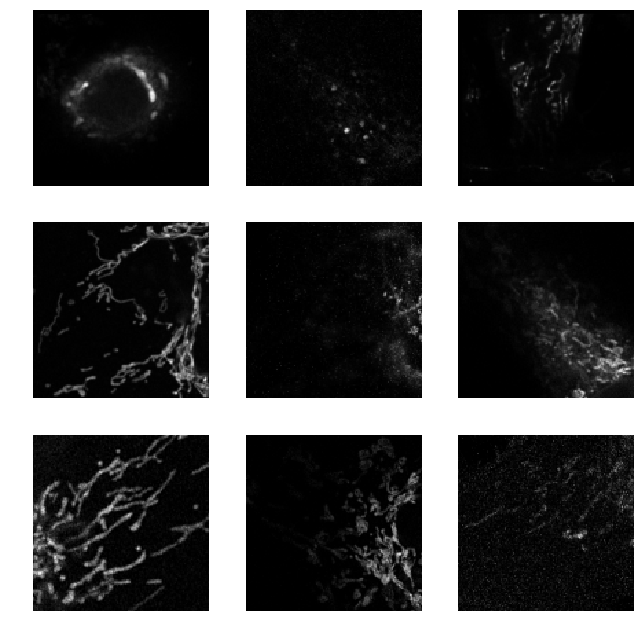

In [12]:
data.show_batch(ds_type=DatasetType.Valid, rows=3, figsize=(9,9))

In [13]:
def gram_matrix(x):
    n,c,h,w = x.size()
    x = x.view(n, c, -1)
    return (x @ x.transpose(1,2))/(c*h*w)

In [14]:
base_loss = F.l1_loss

In [15]:
vgg_m = vgg16_bn(True).features.cuda().eval()
requires_grad(vgg_m, False)

In [16]:
blocks = [i-1 for i,o in enumerate(children(vgg_m)) if isinstance(o,nn.MaxPool2d)]
blocks, [vgg_m[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [17]:
class FeatureLoss(nn.Module):
    def __init__(self, m_feat, layer_ids, layer_wgts):
        super().__init__()
        self.m_feat = m_feat
        self.loss_features = [self.m_feat[i] for i in layer_ids]
        self.hooks = hook_outputs(self.loss_features, detach=False)
        self.wgts = layer_wgts
        self.metric_names = ['pixel',] + [f'feat_{i}' for i in range(len(layer_ids))
              ] + [f'gram_{i}' for i in range(len(layer_ids))]

    def make_features(self, x, clone=False):
        self.m_feat(x)
        return [(o.clone() if clone else o) for o in self.hooks.stored]
    
    def forward(self, input, target):
        out_feat = self.make_features(target, clone=True)
        in_feat = self.make_features(input)
        self.feat_losses = [base_loss(input,target)]
        self.feat_losses += [base_loss(f_in, f_out)*w
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.feat_losses += [base_loss(gram_matrix(f_in), gram_matrix(f_out))*w**2 * 5e3
                             for f_in, f_out, w in zip(in_feat, out_feat, self.wgts)]
        self.metrics = dict(zip(self.metric_names, self.feat_losses))
        return sum(self.feat_losses)
    
    def __del__(self): self.hooks.remove()

In [18]:
feat_loss = FeatureLoss(vgg_m, blocks[2:5], [5,15,2])

In [19]:
wd = 1e-3
learn = unet_learner(data, arch, wd=wd, loss_func=feat_loss, 
                     callback_fns=LossMetrics, blur=True, norm_type=NormType.Weight,
                     metrics=superres_metrics, model_dir=model_dir)
gc.collect();

In [20]:
# learn.lr_find()
# learn.recorder.plot()

In [21]:
lr = 1e-3
def do_fit(save_name, lrs=slice(lr), pct_start=0.9):
    learn.fit_one_cycle(30, lrs, pct_start=pct_start)
    learn.save(save_name)
    learn.show_results(rows=1, imgsize=5)
    learn.recorder.plot_losses()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,4.336098,4.364051,5.448925,0.045425,-7.136551,1.879549,0.269029,0.323726,0.052755,0.701344,1.108149,0.029499
2,4.019723,3.768687,3.163591,0.034508,-4.993290,1.665855,0.244604,0.279847,0.043952,0.600707,0.910678,0.023044
3,3.773298,3.461184,2.990000,0.045727,-4.744348,1.584077,0.225470,0.251531,0.040399,0.551800,0.786676,0.021231
4,3.571554,3.427017,3.273089,0.041789,-5.129246,1.654247,0.213042,0.237468,0.038671,0.523151,0.740137,0.020302
5,3.405392,3.296526,3.128749,0.061597,-4.926852,1.602994,0.203115,0.225429,0.038028,0.499356,0.706967,0.020638
6,3.263883,3.054118,2.656393,0.097175,-4.219608,1.483196,0.190638,0.213759,0.036268,0.462745,0.647243,0.020270
7,3.140158,3.268479,3.418552,0.058690,-5.309854,1.666244,0.186934,0.216391,0.037964,0.459526,0.679888,0.021532
8,3.017040,2.809079,2.191126,0.164736,-3.386409,1.358380,0.169995,0.196084,0.034461,0.419311,0.610846,0.020003
9,2.896296,3.034564,3.512441,0.179287,-5.387095,1.539890,0.172011,0.207640,0.038714,0.434288,0.618995,0.023026
10,2.772765,2.467173,1.515057,0.303240,-1.774407,1.114956,0.157285,0.185571,0.031661,0.383369,0.576166,0.018165


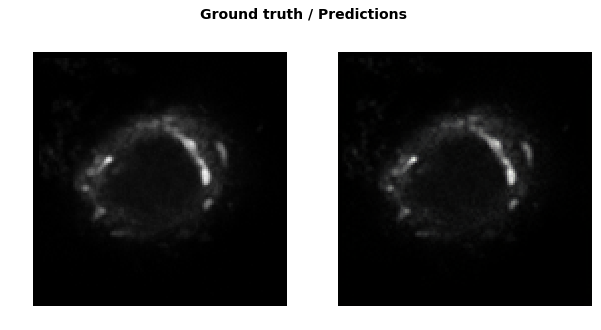

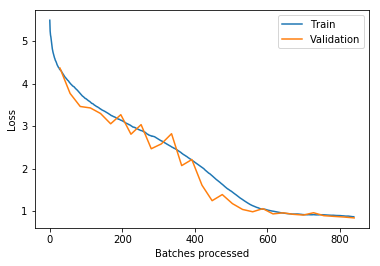

In [22]:
do_fit('1a', slice(lr*10))

In [23]:
learn.unfreeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.819122,0.826363,0.012996,0.828372,18.900066,0.065237,0.103078,0.124418,0.019353,0.173668,0.329359,0.011249
2,0.824798,0.836903,0.013903,0.826023,18.603821,0.067804,0.103357,0.125318,0.019458,0.177298,0.332446,0.011224
3,0.829657,0.823154,0.012981,0.828673,18.905394,0.065314,0.102933,0.124132,0.019305,0.172411,0.327821,0.011237
4,0.829287,0.823280,0.013173,0.828380,18.840855,0.065728,0.102939,0.124197,0.019263,0.172226,0.327730,0.011196
5,0.827926,0.818563,0.012970,0.829049,18.909588,0.065393,0.102951,0.123743,0.019283,0.170396,0.325519,0.011279
6,0.832276,0.824162,0.013483,0.827997,18.738670,0.066728,0.103074,0.124198,0.019247,0.173113,0.326648,0.011155
7,0.828285,0.817839,0.013585,0.825403,18.705723,0.066761,0.102783,0.123545,0.019026,0.169266,0.325469,0.010989
8,0.825784,0.820729,0.013223,0.829510,18.824844,0.065857,0.102861,0.123825,0.019204,0.171584,0.326243,0.011156
9,0.833605,0.826467,0.014237,0.824544,18.500292,0.069240,0.103192,0.124243,0.019142,0.172503,0.327087,0.011061
10,0.832520,0.816917,0.013491,0.828241,18.737309,0.066678,0.102561,0.123504,0.019089,0.169838,0.324204,0.011044


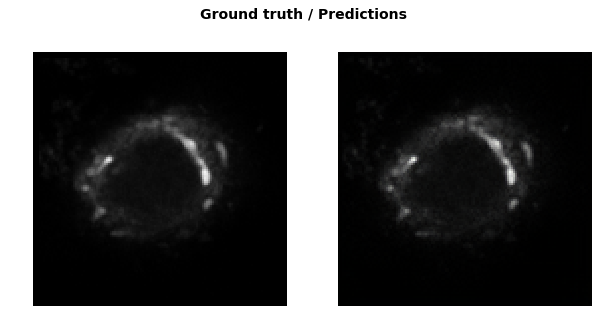

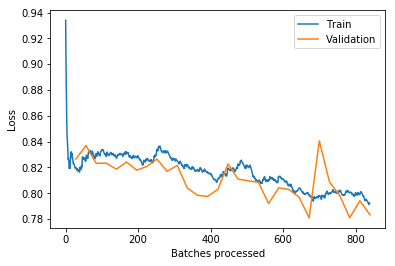

In [24]:
do_fit('1b', slice(1e-5,1e-3))

In [25]:
data = get_data(src, bs//2,size*2)
learn.data = data
learn.freeze()

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,1.010858,0.734642,0.019624,0.701245,17.158619,0.079001,0.130469,0.126598,0.016598,0.167821,0.207011,0.007143
2,0.954197,0.734139,0.019753,0.702402,17.127211,0.081883,0.130009,0.126399,0.016040,0.167576,0.205382,0.006852
3,0.923642,0.726325,0.019602,0.696773,17.160669,0.081613,0.129937,0.126109,0.015730,0.163222,0.203098,0.006615
4,0.903432,0.725946,0.020048,0.692261,17.059822,0.084228,0.130377,0.126584,0.015742,0.162207,0.200272,0.006537
5,0.878878,0.713600,0.019752,0.691242,17.127747,0.079980,0.130714,0.126700,0.015842,0.158440,0.195295,0.006630
6,0.850716,0.691858,0.019683,0.688811,17.145205,0.079061,0.130135,0.125053,0.015351,0.152129,0.183842,0.006287
7,0.836772,0.681955,0.019491,0.689820,17.188379,0.079176,0.130188,0.124965,0.015482,0.146788,0.178991,0.006365
8,0.824503,0.688105,0.019596,0.688635,17.164230,0.079190,0.130131,0.124947,0.015405,0.147923,0.184199,0.006309
9,0.813055,0.680183,0.019883,0.685149,17.102551,0.079693,0.129665,0.124110,0.015051,0.144006,0.181574,0.006083
10,0.799543,0.678701,0.019835,0.688750,17.111521,0.079778,0.130133,0.124776,0.015212,0.145964,0.176689,0.006147


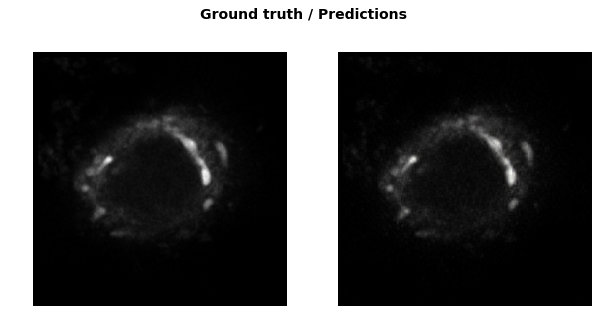

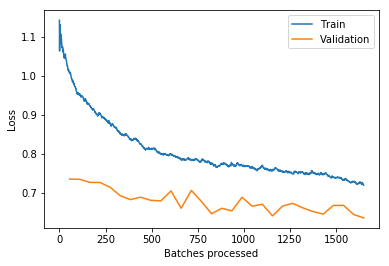

In [26]:
do_fit('2a')

In [27]:
learn.unfreeze()

In [ ]:
do_fit('2b', slice(1e-5,1e-3), pct_start=0.3)

epoch,train_loss,valid_loss,mse_loss,ssim,psnr,pixel,feat_0,feat_1,feat_2,gram_0,gram_1,gram_2
1,0.709623,0.652234,0.020953,0.671708,16.868029,0.082008,0.128929,0.121161,0.014535,0.128575,0.171037,0.005988
2,0.714815,0.638827,0.021365,0.667549,16.784405,0.082439,0.128683,0.120542,0.014536,0.123318,0.163257,0.006051
3,0.723216,0.643923,0.019794,0.673431,17.120529,0.080991,0.128923,0.121341,0.014604,0.125031,0.167001,0.006031
4,0.726965,0.634144,0.022091,0.669224,16.637968,0.084186,0.128855,0.120345,0.014487,0.123046,0.157224,0.006001
5,0.721255,0.630434,0.020050,0.676847,17.064203,0.079787,0.128623,0.119116,0.014500,0.121663,0.160759,0.005986
6,0.724522,0.628504,0.021058,0.670913,16.853590,0.081700,0.128144,0.120074,0.014433,0.119739,0.158432,0.005982
7,0.727134,0.660304,0.020233,0.680956,17.027195,0.080817,0.129147,0.122174,0.014800,0.134378,0.172886,0.006102
8,0.721357,0.632537,0.020525,0.669140,16.960466,0.081326,0.128970,0.120371,0.014538,0.121735,0.159581,0.006016
9,0.729890,0.644335,0.020499,0.678890,16.964647,0.080834,0.128549,0.121807,0.014972,0.128200,0.163643,0.006330
10,0.734308,0.642958,0.022584,0.663759,16.536257,0.085144,0.128928,0.121182,0.014529,0.125206,0.161959,0.006011


In [29]:
bs,size = 2,512
data = get_data(src_mr, bs, size)
learn.data = data
do_fit('3', slice(1e-5,1e-3), pct_start=0.3)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [30]:
learn.data = data
tst_imgs  = list(Path('/DATA/WAMRI/salk/uri/Image_restoration_data/newimg/').iterdir())

In [31]:
fn = tst_imgs[1]
img = open_grayscale(fn)

a,b,c = learn.predict(img)
img2 = PIL.Image.open(fn)

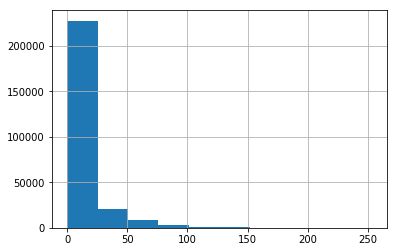

In [32]:
pd.Series(np.array(img2).flatten()).hist()

In [33]:
agray = Image(a.data[0:1,:,:])

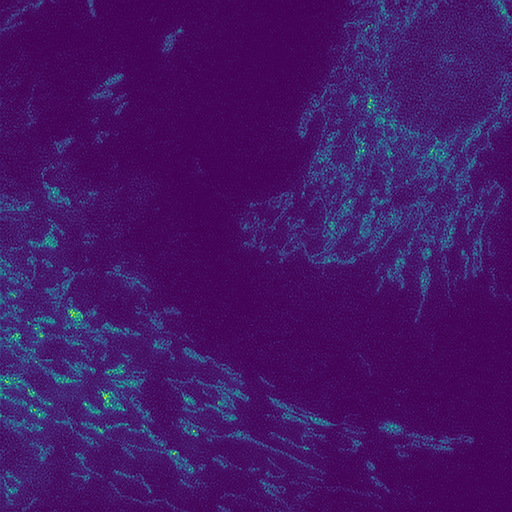

In [36]:
agray

In [37]:
ssim.ssim(agray.data[None], img.data[None])

tensor(0.5792)